In [19]:
#import dependencies
import requests
import time
import sqlite3
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint as pp
from bs4 import BeautifulSoup as bs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve, average_precision_score, auc
from sklearn.svm import SVC, SVR
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
# create connection to database
warnings.filterwarnings('ignore')

con = sqlite3.connect("db/movies.db")
sql = f"""
   SELECT * FROM movie_data
   """

# bring in db to pandas dataframe
movieDf = pd.read_sql(sql, con)
movieDf.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,production_companies_count,genres_count,popularity,vote_count,vote_average,total_actor_starpower,release_month,holiday_month,tot_noms,tot_wins
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,4.0,4,185.070892,12114.0,7.2,5.334665,12,1,0,0
1,Color,Stephen Sommers,106.0,106.0,208.0,855.0,Jason Flemyng,3000.0,11146409.0,Action|Adventure|Horror|Sci-Fi,...,3.0,4,6.922458,155.0,6.0,10.933174,01,0,0,0
2,Color,Terrence Malick,222.0,150.0,0.0,855.0,Michael Greyeyes,23000.0,12712093.0,Biography|Drama|History|Romance,...,5.0,3,7.694502,336.0,6.4,11.013046,12,1,0,0
3,Color,Brian Robbins,76.0,98.0,48.0,722.0,Joel David Moore,21000.0,61112916.0,Comedy|Family|Fantasy,...,3.0,2,4.878907,138.0,4.5,13.698882,03,0,1,0
4,Color,Brad Peyton,178.0,94.0,62.0,722.0,Dwayne Johnson,14000.0,103812241.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,...,3.0,3,9.46307,1050.0,5.8,6.475240,01,0,0,0


In [3]:
# review columns
for col in movieDf.columns.sort_values().values:
    print(col)

actor_1_facebook_likes
actor_1_name
actor_1_score
actor_2_facebook_likes
actor_2_name
actor_2_score
actor_3_facebook_likes
actor_3_name
actor_3_score
aspect_ratio
budget
cast_total_facebook_likes
color
content_rating
country
director_facebook_likes
director_name
director_score
duration
facenumber_in_poster
genres
genres_count
gross
gross_margin
holiday_month
imdb_num_code
imdb_score
language
movie_facebook_likes
movie_imdb_link
movie_title
num_critic_for_reviews
num_user_for_reviews
num_voted_users
plot_keywords
popularity
production_companies_count
rating_numeric
release_date
release_month
revenue
success_bins
successful
title_year
tot_noms
tot_wins
total_actor_starpower
vote_average
vote_count


In [28]:
# create table for model purposes
modelDf = movieDf[["duration","facenumber_in_poster","rating_numeric","budget","revenue","gross_margin", 
                   "successful","director_score","production_companies_count","total_actor_starpower","release_month",
                   "holiday_month","tot_wins","tot_noms"]]
modelDf = modelDf.dropna()
modelDf.head(10)

,duration,facenumber_in_poster,rating_numeric,budget,revenue,gross_margin,successful,director_score,production_companies_count,total_actor_starpower,release_month,holiday_month,tot_wins,tot_noms
0,178.0,0.0,3,237000000.0,523505847.0,0.688365,1,3.091853,4.0,5.334665,12,1,0,0
1,106.0,0.0,4,45000000.0,-33853591.0,-3.037175,0,1.766773,3.0,10.933174,01,0,0,0
2,150.0,0.0,3,30000000.0,-17287907.0,-1.359958,0,1.325080,5.0,11.013046,12,1,0,0
3,98.0,0.0,2,50000000.0,11112916.0,0.181842,1,2.650160,3.0,13.698882,03,0,0,1
4,94.0,3.0,2,79000000.0,24812241.0,0.239011,1,1.325080,3.0,6.475240,01,0,0,0
5,146.0,4.0,4,100000000.0,-4671063.0,-0.048999,0,0.441693,4.0,3.409212,05,0,1,2
6,90.0,0.0,3,25000000.0,-6139597.0,-0.325528,0,2.650160,1.0,2.816560,09,0,0,0
7,121.0,0.0,4,83000000.0,-16137932.0,-0.241362,0,2.208466,1.0,6.499734,11,1,0,0
8,101.0,1.0,4,42000000.0,-28791977.0,-2.179885,0,0.883387,8.0,3.409212,08,0,0,0
9,110.0,1.0,4,45000000.0,25001065.0,0.357153,1,0.883387,4.0,3.409212,08,0,0,0


In [29]:
modelDf["successful"].value_counts()

1    1950
0    1687
Name: successful, dtype: int64

In [30]:
# Assign X (data) and y (target)
X = modelDf[["rating_numeric","director_score","production_companies_count","total_actor_starpower","release_month",
             "tot_wins","tot_noms"]]
y = modelDf["successful"].values.reshape(-1, 1)
print(X.shape, y.shape)

(3637, 7) (3637, 1)


In [31]:
# split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1158, train_size=0.80, stratify=y)

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

In [32]:
pd.DataFrame(y_test)[0].value_counts()

1    390
0    338
Name: 0, dtype: int64

In [33]:
# transform the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Logistic Regression Model 

In [34]:
#build logistic model 
model = LogisticRegression()

#fit on training data
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# Use our model to predict a value
predicted = model.predict(X_test_scaled)

# Score the prediction with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
testing_score = model.score(X_test_scaled,y_test)

print(f"testing_score: {testing_score}")

testing_score: 0.5563186813186813


# Deep Neural Network

In [36]:
# creating the empty squential network
modelNN = Sequential()

In [37]:
# Add the first layer where the input dimensions are features used in the model
modelNN.add(Dense(units=21, activation='relu', input_dim=7))

Instructions for updating:
Colocations handled automatically by placer.


In [38]:
# Add the hidden layer
modelNN.add(Dense(units=21, activation='relu'))

In [39]:
# Add output layer, 2 units for "classes" of output, i.e. Yes or No 
modelNN.add(Dense(units=2, activation='softmax'))

In [40]:
# Compile the model using the adaptive learning rate optimizer "adam", spare_categorical_crossentropy
# for the loss function since we did not one-hot encode the labels and used accuracy for the training metrics.
modelNN.compile(optimizer='adagrad',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# Use the training data to fit (train) the model
modelNN.fit(
    X_train_scaled,
    y_train,
    epochs=200,
    shuffle=True,
    verbose=2
)

Epoch 1/200
 - 0s - loss: 0.6897 - acc: 0.5438
Epoch 2/200
 - 0s - loss: 0.6813 - acc: 0.5624
Epoch 3/200
 - 0s - loss: 0.6792 - acc: 0.5638
Epoch 4/200
 - 0s - loss: 0.6775 - acc: 0.5703
Epoch 5/200
 - 0s - loss: 0.6765 - acc: 0.5717
Epoch 6/200
 - 0s - loss: 0.6756 - acc: 0.5730
Epoch 7/200
 - 0s - loss: 0.6746 - acc: 0.5693
Epoch 8/200
 - 0s - loss: 0.6743 - acc: 0.5789
Epoch 9/200
 - 0s - loss: 0.6737 - acc: 0.5782
Epoch 10/200
 - 0s - loss: 0.6731 - acc: 0.5820
Epoch 11/200
 - 0s - loss: 0.6727 - acc: 0.5827
Epoch 12/200
 - 0s - loss: 0.6722 - acc: 0.5844
Epoch 13/200
 - 0s - loss: 0.6718 - acc: 0.5837
Epoch 14/200
 - 0s - loss: 0.6713 - acc: 0.5840
Epoch 15/200
 - 0s - loss: 0.6709 - acc: 0.5834
Epoch 16/200
 - 0s - loss: 0.6705 - acc: 0.5827
Epoch 17/200
 - 0s - loss: 0.6702 - acc: 0.5875
Epoch 18/200
 - 0s - loss: 0.6698 - acc: 0.5861
Epoch 19/200
 - 0s - loss: 0.6694 - acc: 0.5858
Epoch 20/200
 - 0s - loss: 0.6688 - acc: 0.5878
Epoch 21/200
 - 0s - loss: 0.6686 - acc: 0.5909
E

Epoch 171/200
 - 0s - loss: 0.6496 - acc: 0.6095
Epoch 172/200
 - 0s - loss: 0.6496 - acc: 0.6078
Epoch 173/200
 - 0s - loss: 0.6495 - acc: 0.6102
Epoch 174/200
 - 0s - loss: 0.6495 - acc: 0.6091
Epoch 175/200
 - 0s - loss: 0.6494 - acc: 0.6078
Epoch 176/200
 - 0s - loss: 0.6493 - acc: 0.6122
Epoch 177/200
 - 0s - loss: 0.6493 - acc: 0.6085
Epoch 178/200
 - 0s - loss: 0.6492 - acc: 0.6085
Epoch 179/200
 - 0s - loss: 0.6492 - acc: 0.6098
Epoch 180/200
 - 0s - loss: 0.6491 - acc: 0.6126
Epoch 181/200
 - 0s - loss: 0.6490 - acc: 0.6081
Epoch 182/200
 - 0s - loss: 0.6489 - acc: 0.6109
Epoch 183/200
 - 0s - loss: 0.6489 - acc: 0.6126
Epoch 184/200
 - 0s - loss: 0.6488 - acc: 0.6112
Epoch 185/200
 - 0s - loss: 0.6487 - acc: 0.6081
Epoch 186/200
 - 0s - loss: 0.6487 - acc: 0.6116
Epoch 187/200
 - 0s - loss: 0.6486 - acc: 0.6146
Epoch 188/200
 - 0s - loss: 0.6486 - acc: 0.6095
Epoch 189/200
 - 0s - loss: 0.6485 - acc: 0.6098
Epoch 190/200
 - 0s - loss: 0.6485 - acc: 0.6102
Epoch 191/200
 - 0s 

In [42]:
# evaluate model by using test data
model_loss, model_accuracy = modelNN.evaluate(
    X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

 - 0s - loss: 0.6760 - acc: 0.5742
Loss: 0.6759922550274775, Accuracy: 0.5741758346557617


# Calculate ROC Curve vs Precision Recall Curve

##### Generally, the use of ROC curves and precision-recall curves are as follows:
#### ROC curves should be used when there are roughly equal numbers of observations for each class.
#### Precision-Recall curves should be used when there is a moderate to large class imbalance.

In [43]:
# predict probabilities
probs = modelNN.predict_proba(X_test_scaled)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

In [44]:
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)

AUC: 0.594


In [45]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

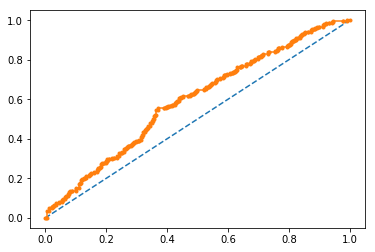

In [46]:
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# Precision Recall Curve

In [47]:
# predict class values
yClass = model.predict(X_test_scaled)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, yClass)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

TypeError: 'numpy.float64' object is not callable

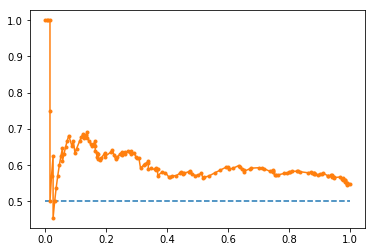

In [54]:
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

# Decision Tree Model w/o Hyper Parameter Tuning

In [48]:
# create model instance
modelDT = tree.DecisionTreeClassifier()

In [49]:
# Fit the classifier to the data
modelDT = modelDT.fit(X_train_scaled, y_train)

In [51]:
# Calculate the R2 score for the test data
score = modelDT.score(X_test_scaled, y_test)

print(f"Decision Tree Score: {score}")

Decision Tree Score: 0.5604395604395604


# Decision Tree Model w/ Hyper Parameter Tuning

In [70]:
# create model instance
modelDT1 = tree.DecisionTreeClassifier(random_state=1234)

In [71]:
# define hyper parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[123]}

In [72]:
# compile models with hyper parameters sets
modelDT1 = GridSearchCV(modelDT1, param_grid=params, n_jobs=-1)

In [73]:
# train the hyper parameter tuned DT model with the training data
modelDT1.fit(X_train_scaled,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1234,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7,

In [82]:
# print best parameters within the tuned DT model
print(f"Best Hyper Parameters: {modelDT1.best_params_}")

# make predictions with tuned DT model
predictionDT1 = modelDT1.predict(X_test_scaled)

# print accuracy (score) of tuned DT model
print(f"Accuracy: {metrics.accuracy_score(predictionDT1,y_test)}")

Best Hyper Parameters: {'max_features': 'auto', 'min_samples_leaf': 11, 'min_samples_split': 2, 'random_state': 123}
Accuracy: 0.5508241758241759


# Random Forest Model w/o Hyper Parameter Tuning

In [88]:
# Create the RF instance
rf = RandomForestClassifier(n_estimators=200)

# fit the RF model with training data
rf = rf.fit(X_train_scaled, y_train)

# score the RF model using testing data
print(f"RF Score: {rf.score(X_test_scaled,y_test)}")

RF Score: 0.5618131868131868


# Random Forest Model w/ Hyper Parameter Tuning

In [93]:
# Create the RF instance
rf1 = RandomForestClassifier()

In [94]:
#Hyper Parameters Set for decision tree
params = {'criterion':['gini','entropy'],
          'n_estimators':[50,100,200],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[3,4,5,6,7], 
          'random_state':[123],
          'n_jobs':[-1]}

In [95]:
# create models with hyper parameters sets
modelRf1 = GridSearchCV(rf1, param_grid=params, n_jobs=-1)

In [96]:
# train the hyper parameter tuned RF model with the training data
modelRf1.fit(X_train_scaled,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [116]:
# print best  hyper parameters set
print(f"Best Hyper Parameters: {modelRf1.best_params_}")

# make predicition with test data
predictionRf1 = modelRf1.predict(X_test_scaled)

# print score for tuned RF model
print(f"\n")
print(f"Accuracy: {metrics.accuracy_score(predictionRf1,y_test)}")

Best Hyper Parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 123}


Accuracy: 0.5714285714285714


In [109]:
print(f"Tuned RF Model Feature Importances:\n{modelRf1.best_estimator_.feature_importances_}")

Tuned RF Model Feature Importances:
[0.0737611  0.15846131 0.15838497 0.31665917 0.18101607 0.02833611
 0.08338128]


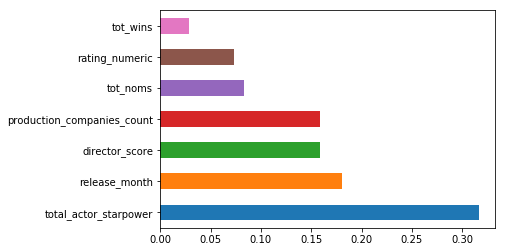

In [115]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(modelRf1.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Support Vector Machine w/o Hyper Parameter Tuning

In [11]:
# Create a support vector machine linear classifer and fit it to the training data.

target_names = ["not successful", "successful"]

modelSVC1 = SVC(kernel='linear')
modelSVC1.fit(X_train_scaled, y_train)

modelSVC2 = SVC(kernel='rbf')
modelSVC2.fit(X_train_scaled, y_train)

modelSVC3 = SVC(kernel='poly')
modelSVC3.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [12]:
# Print model scores using the test data to compare
print(f"Linear SVC Model: {modelSVC1.score(X_test,y_test)}")
print(f"RBF SVC Model: {modelSVC2.score(X_test,y_test)}")
print(f"Polynomial SVC Model: {modelSVC3.score(X_test,y_test)}")

Linear SVC Model: 0.521978021978022
RBF SVC Model: 0.45604395604395603
Polynomial SVC Model: 0.4684065934065934


# Support Vector Machine w/ Hyper Parameter Tuning

In [119]:
# create support vector classifier 
modelSVC = SVC()

#defining hyper parameters
params = {'C': [5,6,7,8,9,10], 
          'kernel': ['linear','rbf'],
          'gamma': [0.1,1,10,100]}

#Making models with hyper parameters sets
modelSVC = GridSearchCV(modelSVC, param_grid=params, n_jobs=-1)

In [120]:
#Learning
modelSVC.fit(X_train_scaled,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [5, 6, 7, 8, 9, 10], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [121]:
#The best hyper parameters set
print(f"Best Hyper Parameters: {modelSVC.best_params_}")

Best Hyper Parameters: {'C': 5, 'gamma': 0.1, 'kernel': 'linear'}


In [122]:
# make prediction using test data
prediction = modelSVC.predict(X_test_scaled)

In [123]:
#evaluation(Accuracy)
print(f"Accuracy: {metrics.accuracy_score(prediction,y_test)}")

Accuracy: 0.5467032967032966


# Summary of Models and Scores

In [118]:
print(f"Models WITHOUT Hyper Parameter Tuning")
print(f"------------------")
print(f"Decision Tree: {modelDT.score(X_test_scaled, y_test)}")
print(f"Random Forest: {rf.score(X_test_scaled, y_test)}")
print(f"Support Vector Machine: {modelSVC1.score(X_test,y_test)}")


print("-------------------------")
print(f"Model scores WITH Hyper Parameter Tuning")
print(f"Decision Tree: {metrics.accuracy_score(predictionDT1,y_test)}")
print(f"Random Forest: {metrics.accuracy_score(predictionRf1,y_test)}")
print(f"Support Vector Machine: {metrics.accuracy_score(prediction,y_test)}")

Models WITHOUT Hyper Parameter Tuning
------------------
Decision Tree: 0.5604395604395604
Random Forest: 0.5618131868131868
Support Vector Machine: 0.521978021978022
-------------------------
Model scores WITH Hyper Parameter Tuning
Decision Tree: 0.5508241758241759
Random Forest: 0.5714285714285714
Support Vector Machine: 0.5782967032967034
